In [1]:
import warnings

warnings.filterwarnings('ignore')
import shutil
import tensorflow as tf

from heatmaps_utils import *
from keras.applications.inception_v3 import preprocess_input

Using TensorFlow backend.


In [2]:
## GPU config
gpus = [0]
configtf = tf.ConfigProto(allow_soft_placement=True)
configtf.gpu_options.allow_growth = True
#configtf.gpu_options.visible_device_list = ','.join(str(gpu) for gpu in gpus)
init = tf.global_variables_initializer()
sess = tf.Session(config=configtf)
sess.run(init)

In [3]:
EXPERIMENT_TYPE='unbiased_iou_pannuke'
# SET PROCESS TITLE
import setproctitle
setproctitle.setproctitle(EXPERIMENT_TYPE)
import sys
sys.path.append('/home/mara/camnet')
#from functions import *
#from models import getModel

#model_folder='/home/mara/camnet/cam1617_2009/'
#CONFIG_FILE=model_folder + 'config.cfg'
#settings = parseTrainingOptions(CONFIG_FILE)
#print settings

In [4]:
keras.backend.clear_session()

NameError: name 'keras' is not defined

In [4]:
#LOAD MODEL
global model
import model_utils
reload(model_utils)
from model_utils import *
model=get_random_baseline_model()

In [5]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 111, 111, 32) 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 111, 111, 32) 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

In [6]:
last_conv='mixed10'

In [7]:
import os
res_folder = 'results/'
new_folder = res_folder + EXPERIMENT_TYPE
if not os.path.exists(new_folder):
    os.makedirs(new_folder)
#shutil.copy2(src=CONFIG_FILE, dst=os.path.join(new_folder, '.'))
import h5py as hd
# DATA PATHS
cam16 = hd.File('/mnt/nas2/results/IntermediateResults/Camelyon/ultrafast/cam16_500/patches.hdf5', 'r')
all500 = hd.File('/mnt/nas2/results/IntermediateResults/Camelyon/ultrafast/all500/patches.hdf5', 'r')
extra17 = hd.File('/mnt/nas2/results/IntermediateResults/Camelyon/ultrafast/extra17/patches.hdf5', 'r')
tumor_extra17=hd.File('/mnt/nas2/results/IntermediateResults/Camelyon/ultrafast/1129-1155/patches.hdf5','r')
test2 = hd.File('/mnt/nas2/results/IntermediateResults/Camelyon/ultrafast/test_data2/patches.hdf5','r')
pannuke= hd.File('/mnt/nas2/results/IntermediateResults/Camelyon/pannuke/patches.hdf5', 'r',)
#
global data
data={'cam16':cam16,'all500':all500,'extra17':extra17, 'tumor_extra17':tumor_extra17, 'test_data2': test2, 'pannuke':pannuke}

# DATA SPLIT CSVs
train_csv=open('/mnt/nas2/results/IntermediateResults/Camelyon/train_shuffle.csv', 'r')
val_csv=open('/mnt/nas2/results/IntermediateResults/Camelyon/val_shuffle.csv', 'r')
test_csv=open('/mnt/nas2/results/IntermediateResults/Camelyon/test_shuffle.csv', 'r')
train_list=train_csv.readlines()
val_list=val_csv.readlines()
test_list=test_csv.readlines()
test2_csv = open('/mnt/nas2/results/IntermediateResults/Camelyon/test2_shuffle.csv', 'r')
test2_list=test2_csv.readlines()
test2_csv.close()
train_csv.close()
val_csv.close()
test_csv.close()

data_csv=open('/mnt/nas2/results/IntermediateResults/Camelyon/pannuke/pannuke_train_shuffled.csv', 'r')
data_list=data_csv.readlines()
data_csv.close()
sys.path.append('/home/mara/multitask_adversarial/lib/TASK_2_UC1/')
from normalizers import ReinhardNormalizer

# STAIN NORMALIZATION
def get_normalizer(patch, save_folder=''):
    normalizer = ReinhardNormalizer()
    normalizer.fit(patch)
    np.save('{}/normalizer'.format(save_folder),normalizer)
    np.save('{}/normalizing_patch'.format(save_folder), patch)
    print('Normalisers saved to disk.')
    return normalizer

def normalize_patch(patch, normalizer):
    return np.float64(normalizer.transform(np.uint8(patch)))

def get_keys(l):
    db_name=l.split(', ')[0]
    entry_path=l.split(', ')[1]
    patch_no=l.split(', ')[2]
    return db_name, entry_path, int(patch_no)

def get_class_name(entry_path):
    if 'normal' in entry_path:
        return 'normal'
    else: 
        return 'tumor'
#    return entry_path.split('/')[0]

def load_patch_mask(patch_address, patch_idx, source_fld=''):
    mask=np.zeros((224,224,4))
    patch_path=source_fld+'/{}'.format(patch_idx) 
    #import pdb; pdb.set_trace()
    try:
        for nuclei_mask in os.listdir(patch_path):
            mask += plt.imread(patch_path+'/'+nuclei_mask)
        n_nuclei=len(os.listdir(patch_path))
        return mask, n_nuclei
    except:
        patch_path=source_fld+patch_address.split('/node')[0]+'/{}'.format(patch_idx)
        #print patch_path
        for nuclei_mask in os.listdir(patch_path):
            mask += plt.imread(patch_path+'/'+nuclei_mask)
        n_nuclei=len(os.listdir(patch_path))
        return mask, n_nuclei

# LOAD DATA NORMALIZER
global normalizer
db_name, entry_path, patch_no = get_keys(data_list[0])
normalization_reference_patch = data[db_name][entry_path][patch_no]
normalizer = get_normalizer(normalization_reference_patch, save_folder=new_folder)

Using brightness standardization
Normalisers saved to disk.


In [8]:
def get_cam_model_resnet101(model, last_conv_layer, pred_layer):
    n_classes = model.output_shape[-1]
    final_params = model.get_layer(pred_layer).get_weights()
    final_params = (final_params[0].reshape(1, 1, -1, n_classes), final_params[1])

    last_conv_output = model.get_layer(last_conv_layer).output
    # upgrade keras to 2.2.3 in order to use UpSampling2D with bilinear interpolation
    # x = UpSampling2D(size=(32, 32))(last_conv_output)
    x = Conv2D(filters=n_classes, kernel_size=(1, 1), name='predictions_2')(last_conv_output)

    cam_model = Model(inputs=model.input, outputs=[model.output, x])
    cam_model.get_layer('predictions_2').set_weights(final_params)
    return cam_model

def postprocess(preds, cams, top_k=1):
    idxes = np.argsort(preds[0])[-top_k:]
    class_activation_map = np.zeros_like(cams[0, :, :, 0])
    for i in idxes:
        class_activation_map += cams[0, :, :, i]
    return class_activation_map

def get_cam_model_iv3(model, last_conv_layer, pred_layer):
    n_classes = model.output_shape[-1]
    final_params = model.get_layer(pred_layer).get_weights()
    final_params = (final_params[0].reshape(1, 1, -1, n_classes), final_params[1])

    last_conv_output = model.get_layer(last_conv).output
    # upgrade keras to 2.2.3 in order to use UpSampling2D with bilinear interpolation
    # x = UpSampling2D(size=(32, 32))(last_conv_output)
    x = Conv2D(filters=2048, kernel_size=(1, 1), name='extra_layer1_2')(last_conv_output)
    x = Conv2D(filters=512, kernel_size=(1,1), name='extra_layer2_2')(x)
    x = Conv2D(filters=256, kernel_size=(1,1), name='extra_layer3_2')(x)
    x = Conv2D(filters=n_classes, kernel_size=(1,1), name='predictions_2')(x)
    cam_model = Model(inputs=model.input, outputs=[model.output, x])

    final_params = model.get_layer('finetuned_features1').get_weights()
    final_params = (final_params[0].reshape(1, 1, -1, 2048), final_params[1])
    
    cam_model.get_layer('extra_layer1_2').set_weights(final_params)
    final_params = model.get_layer('finetuned_features2').get_weights()
    final_params = (final_params[0].reshape(1, 1, -1, 512), final_params[1])
    cam_model.get_layer('extra_layer2_2').set_weights(final_params)
    final_params = model.get_layer('finetuned_features3').get_weights()
    final_params = (final_params[0].reshape(1, 1, -1, 256), final_params[1])
    cam_model.get_layer('extra_layer3_2').set_weights(final_params)
    final_params = model.get_layer(pred_layer).get_weights()
    final_params = (final_params[0].reshape(1, 1, -1, n_classes), final_params[1])
    cam_model.get_layer('predictions_2').set_weights(final_params)
    
    return cam_model
def cam(model, img, last_conv, original_size, pred_layer=None):
    if pred_layer is None:
        pred_layer = model.layers[-1].name
    cam_model = get_cam_model_iv3(model, last_conv_layer=last_conv, pred_layer=pred_layer)
    preds, cams = cam_model.predict(img)
    class_activation_map = postprocess(preds, cams)
    return cv2.resize(class_activation_map, original_size)


In [9]:
### gradCAM ###
def gradcam(model, img, layer_name, original_size):
    """ Grad-CAM function """
    
    cls = np.argmax(model.predict(img))
    
    y_c = model.output[0, cls]
    conv_output = model.get_layer(layer_name).output
    grads = K.gradients(y_c, conv_output)[0]

    # Get outputs and grads
    gradient_function = K.function([model.input], [conv_output, grads])
    output, grads_val = gradient_function([img])
    output, grads_val = output[0, :], grads_val[0, :, :, :]
    
    weights = np.mean(grads_val, axis=(0, 1)) # Passing through GlobalAveragePooling

    cam = np.dot(output, weights) # multiply
    cam = np.maximum(cam, 0)      # Passing through ReLU
    #cam /= np.max(cam)            # scale 0 to 1.0

    cam = cv2.resize(cam, original_size)
    return cam
### gradCAM++ ###
def gradcam_plus_plus(model, img, layer_name, original_size):
    """ Grad-CAM++ function """
    
    cls = np.argmax(model.predict(img))
    y_c = model.output[0, cls]
    conv_output = model.get_layer(layer_name).output
    grads = K.gradients(y_c, conv_output)[0]

    first = K.exp(y_c) * grads
    second = K.exp(y_c) * grads * grads
    third = K.exp(y_c) * grads * grads * grads

    gradient_function = K.function([model.input], [y_c, first, second, third, conv_output, grads])
    y_c, conv_first_grad, conv_second_grad, conv_third_grad, conv_output, grads_val = gradient_function([img])
    global_sum = np.sum(conv_output[0].reshape((-1,conv_first_grad[0].shape[2])), axis=0)

    alpha_num = conv_second_grad[0]
    alpha_denom = conv_second_grad[0] * 2.0 + conv_third_grad[0] * global_sum.reshape((1, 1, conv_first_grad[0].shape[2]))
    alpha_denom = np.where(alpha_denom != 0.0, alpha_denom, np.ones(alpha_denom.shape))
    alphas = alpha_num / alpha_denom # 0


    weights = np.maximum(conv_first_grad[0], 0.0)
    alpha_normalization_constant = np.sum(np.sum(alphas, axis=0), axis=0) # 0
    alphas /= alpha_normalization_constant.reshape((1, 1, conv_first_grad[0].shape[2])) # NAN
    deep_linearization_weights = np.sum((weights * alphas).reshape((-1, conv_first_grad[0].shape[2])), axis=0)

    cam = np.sum(deep_linearization_weights * conv_output[0], axis=2)
    cam = np.maximum(cam, 0) # Passing through ReLU
    #cam /= np.max(cam)       # scale 0 to 1.0  

    cam = cv2.resize(cam, original_size)
    return cam

In [10]:
test_cvs_ =open('/mnt/nas2/results/IntermediateResults/Camelyon/pannuke/test_pannuke_shuffled.csv', 'r')
test_pannuke_list=test_cvs_.readlines()
pannuke_data=[]
for d in test_pannuke_list:
    if 'pannuke' in d:
        pannuke_data.append(d)

In [11]:
train_list=pannuke_data

In [12]:
len(pannuke_data)

3875

In [13]:
pannuke= hd.File('/mnt/nas2/results/IntermediateResults/Camelyon/pannuke_test/patches.hdf5', 'r',)
data={'cam16':cam16,'all500':all500,'extra17':extra17, 'tumor_extra17':tumor_extra17, 'test_data2': test2, 'pannuke':pannuke}

In [14]:
def binarize_mask(mask):
    return (mask>0)*1
def get_semantic_mask(masks):
    binary_mask={}
    for mask_type in range(6):
        binary_mask[mask_type]=binarize_mask(masks[:,:,mask_type])
    semantic_mask=np.zeros((224,224))    
    for mask_type in range(0,5):
        semantic_mask += (mask_type+1) * binary_mask[mask_type]
    #semantic_mask-=binary_mask[5]
    return semantic_mask
def binarize_all_masks(masks):
    binary_masks={}
    for i in range(6):
        binary_masks[i]=binarize_mask(masks[:,:,i])
    return binary_masks

In [15]:
# creating colormaps for every cell type
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from matplotlib import colors
global neoplastic, inflammatory, connective, dead, epithelial
neoplastic = colors.ListedColormap(['red'])
boundaries = [-1, -0.9, -0.6, -0.3, 0, 0.3, 0.6, 1]
norm = colors.BoundaryNorm(boundaries, neoplastic.N, clip=True)
inflammatory = colors.ListedColormap(['green'])
connective = colors.ListedColormap(['blue'])
dead = colors.ListedColormap(['fuchsia'])
epithelial = colors.ListedColormap(['orange'])


In [16]:
def compute_avg(heatmaps):
    _tmp = heatmaps['SLIC'] + heatmaps['Felzenszwalb']
    _tmp /= 2
    heatmaps['AVG'] = _tmp
    return heatmaps

In [17]:
# creating colormaps for every cell type
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from matplotlib import colors
global neoplastic, inflammatory, connective, dead, epithelial
neoplastic = colors.ListedColormap(['red'])
boundaries = [-1, -0.9, -0.6, -0.3, 0, 0.3, 0.6, 1]
norm = colors.BoundaryNorm(boundaries, neoplastic.N, clip=True)
inflammatory = colors.ListedColormap(['green'])
connective = colors.ListedColormap(['blue'])
dead = colors.ListedColormap(['fuchsia'])
epithelial = colors.ListedColormap(['orange'])


In [18]:
# Segmentation methods used to compute superpixels needed for LIME
seg_methods = {#'Quickshift':segments_quick,
               'SLIC':segments_slic,
               'Felzenszwalb':segments_fz,
              }

# Boxes size should be a divisor of input size
# Too high sizes will give too small boxes and low weights
# for computing Squaregrid (so no impact)
# They used 3/4/6/8/12/16/24 in https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6651753/
boxes_size = []#4, 7, 8, 14, 16, 28] #, 32, 56, 112, 224]
for k in boxes_size:
    assert input_size[0] % k == 0

for k in (boxes_size):
    seg_methods['boxes_{}'.format(k*k)] = k
    
# pertubed_images = []
# pertubed_images_preds = []

def predict(patches, normalizer=normalizer):
    inputs = []
    for patch in patches:
        inputs.append(normalize_patch(patch, normalizer))
    inputs = np.asarray(inputs, dtype=np.float32)
    inputs = preprocess_input(inputs)
#     pertubed_images.extend(patches)
#     pertubed_images_preds.extend(preds)
    return model.predict(inputs)    
    
import tensorflow as tf
input_size=(224,224)
heatmaps_list=[]
nb_tumor=0
nb_normal=0
nb_target=100
for element in train_list[:1000]:
    
    db_name, entry_path, patch_no = get_keys(element)
    _type = get_class_name(entry_path)

    if _type == 'tumor':
        if nb_tumor >= nb_target :
            continue
        nb_tumor += 1
    elif _type == 'normal':
        if nb_normal >= nb_target :
            continue
        nb_normal += 1
    
    path = element.split(',')[1].strip(' ')[:-5]
    masks = data['pannuke'][path+'mask'][0]
    image= data['pannuke'][path+'patch'][0]
    #semantic_mask=get_semantic_mask(masks)
    binary_masks=binarize_all_masks(masks)
    
    #image = data[db_name][entry_path][patch_no]
    #mask_path='/mnt/nas3/bigdatasets/Histopathology_Segmentations/patches_{}/'.format(db_name,entry_path)
    #try:
    #    mask, n_nuclei = load_patch_mask(entry_path, patch_no, source_fld=mask_path)
    #except:
    #    mask = None

    inputs = normalize_patch(image, normalizer)
    inputs = np.expand_dims(inputs, axis=0)
    inputs = preprocess_input(inputs)
    preds = tf.sigmoid(model.predict(inputs)[0]).eval(session=tf.Session())


    _heatmaps = {}
    _heatmaps['path'] = element
    _heatmaps['type'] = _type
    _heatmaps['pred'] = preds
    _heatmaps['original'] = data['pannuke'][path+'patch'][0]
    _heatmaps['mask'] = binary_masks

    ### CAM ###
    _heatmaps['CAM'] = cam(model, inputs, last_conv, input_size)

    ### gradCAM ###
    _heatmaps['gradCAM'] = gradcam(model, inputs, last_conv, input_size)

    ### gradCAM++ ###
    _heatmaps['gradCAM++'] = gradcam_plus_plus(model, inputs, last_conv, input_size)
    heatmaps=compute_cams(_heatmaps)
    
    ### LIME ###
    for name, segmentation_fn in seg_methods.items():
        #if name.startswith('boxes_'):
        #    k = segmentation_fn
        #    segmentation_fn = lambda i : segments_box(i, k, input_size)
        explainer = lime_image.LimeImageExplainer()
        explanation = explainer.explain_instance(image, predict, top_labels=1, hide_color=0,
                                                 num_samples=1000, segmentation_fn=segmentation_fn, num_features=100)

        # Select the same class explained on the figures above.
        ind =  explanation.top_labels[0]

        # Map each explanation weight to the corresponding superpixel
        dict_heatmap = dict(explanation.local_exp[ind])
        heatmap = np.vectorize(dict_heatmap.get)(explanation.segments)
        heatmap = np.nan_to_num(np.asarray(heatmap, dtype=float))
        _heatmaps[name] = heatmap
    
    #compute_avg(_heatmaps)
    #compute_squaregrid(_heatmaps)
    
    heatmaps_list.append(_heatmaps)

#np.save(new_folder+'/LIME_heatmaps_{}tumor_{}normal_{}'.format(nb_tumor, nb_normal, nb_target), np.asarray(heatmaps_list))

100% |########################################################################|
100% |########################################################################|
100% |########################################################################|
100% |########################################################################|
100% |########################################################################|
100% |########################################################################|
100% |########################################################################|
100% |########################################################################|
100% |########################################################################|
100% |########################################################################|
100% |########################################################################|
100% |########################################################################|
100% |##################################

100% |########################################################################|
100% |########################################################################|
100% |########################################################################|
100% |########################################################################|
100% |########################################################################|
100% |########################################################################|
100% |########################################################################|
100% |########################################################################|
100% |########################################################################|
100% |########################################################################|
100% |########################################################################|
100% |########################################################################|
100% |##################################

In [19]:
np.save(new_folder+'/REALLY_RANDOM_FINAL_ALL_HM_LIST', np.asarray(heatmaps_list))

In [ ]:
#split the random hm with the indexes you saved from before

In [20]:
new_folder


'results/unbiased_iou_pannuke'

In [34]:
len(heatmaps_list), nb_tumor, nb_normal

(200, 100, 100)

In [83]:
heatmaps_list=np.load('results/unbiased_iou_pannuke/REALLY_RANDOM_FINAL_ALL_HM_LIST.npy')

In [21]:
#adding nuclei_types info
areas={path: {i:[] for i in range(6)} for path in [h['path'] for h in heatmaps_list]}

image_lists={i:[] for i in range(6)}
for d in heatmaps_list:
    d['nuclei_types']=[]
    
idx=0
for d in heatmaps_list:
    #print d['path']
    path = d['path'].split(',')[1].strip(' ')[:-5]
    masks = data['pannuke'][path+'mask'][0]
    #image= data['pannuke'][path+'patch'][0]
    #semantic_mask=get_semantic_mask(masks)
    binary_masks=binarize_all_masks(masks)
    for i in range(6):
        if np.sum(binary_masks[i])>0: 
            d['nuclei_types'].append(i)
        areas[d['path']][i].append(np.sum(binary_masks[i]))
    idx+=1

In [29]:
np.save('results/AREAS',areas)

In [22]:
all_preds=[]
gt=[]
for d in heatmaps_list:
    print d['pred'], d['type']
    all_preds.append(d['pred'][0])
    if d['type']=='tumor':
        gt.append(1)
    else:
        gt.append(0)

[0.5000249] normal
[0.5000354] tumor
[0.50003433] tumor
[0.5000278] tumor
[0.5000293] tumor
[0.5000351] tumor
[0.50003153] tumor
[0.5000263] tumor
[0.5000339] tumor
[0.5000303] normal
[0.5000288] tumor
[0.50001776] normal
[0.50002474] normal
[0.5000288] normal
[0.50003356] tumor
[0.5000335] tumor
[0.5000108] normal
[0.500032] tumor
[0.50003] tumor
[0.50003076] normal
[0.50002515] tumor
[0.5000363] normal
[0.500027] tumor
[0.50003594] normal
[0.5000319] tumor
[0.50001466] normal
[0.5000204] normal
[0.500032] tumor
[0.5000298] tumor
[0.5000313] tumor
[0.5000243] normal
[0.50002533] tumor
[0.5000301] tumor
[0.5000313] tumor
[0.5000328] tumor
[0.5000305] tumor
[0.50002944] tumor
[0.500035] normal
[0.50003463] tumor
[0.50002104] tumor
[0.50002813] tumor
[0.5000368] tumor
[0.5000289] tumor
[0.50002426] normal
[0.5000339] normal
[0.50002897] tumor
[0.50003135] tumor
[0.50003093] tumor
[0.5000336] normal
[0.50003797] normal
[0.50002444] tumor
[0.5000261] normal
[0.5000239] tumor
[0.5000107] tu

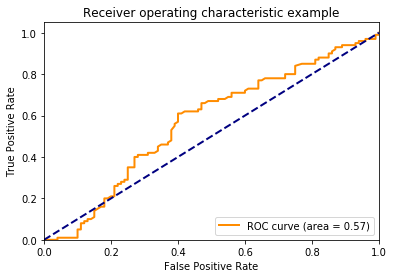

In [23]:
# AUC
import sklearn.metrics
auc=sklearn.metrics.roc_auc_score(gt,all_preds)
fpr, tpr, ths =sklearn.metrics.roc_curve(gt, all_preds)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=2, label='ROC curve (area = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [55]:
heatmaps_list[0]['pred']

array([0.72001594], dtype=float32)

In [93]:
for th in [0.875]:
    heatmaps_normal_list = [d for d in heatmaps_list if d['type'] == 'normal']
    heatmaps_tumor_list = [d for d in heatmaps_list if d['type'] == 'tumor']

    heatmaps_normal_list_pred_ok = [d for d in heatmaps_list if d['type'] == 'normal' and d['pred'] < th]
    heatmaps_tumor_list_pred_ok = [d for d in heatmaps_list if d['type'] == 'tumor' and d['pred'] >= th]
    heatmaps_normal_list_pred_ko = [d for d in heatmaps_list if d['type'] == 'normal' and d['pred'] >= th]
    heatmaps_tumor_list_pred_ko = [d for d in heatmaps_list if d['type'] == 'tumor' and d['pred'] < th]
    print th, len(heatmaps_tumor_list_pred_ok), len(heatmaps_tumor_list_pred_ko), len(heatmaps_normal_list_pred_ko),len(heatmaps_normal_list_pred_ok)
    print 'th: {}, misclassified: '.format(th), len(heatmaps_tumor_list_pred_ko)+ len(heatmaps_normal_list_pred_ko)

 0.875 0 100 0 100
th: 0.875, misclassified:  100


In [ ]:
for th in [0.875]:
    heatmaps_normal_list = [d for d in heatmaps_list if d['type'] == 'normal']
    heatmaps_tumor_list = [d for d in heatmaps_list if d['type'] == 'tumor']

    _idx_heatmaps_normal_list_pred_ok = [idx for idx in range(len(heatmaps_list)) if heatmaps_list[idx]['type'] == 'normal' and heatmaps_list[idx]['pred'] < th]
    _idx_heatmaps_tumor_list_pred_ok = [idx for idx in range(len(heatmaps_list)) if heatmaps_list[idx]['type'] == 'tumor' and heatmaps_list[idx]['pred'] >= th]
    _idx_heatmaps_normal_list_pred_ko = [idx for idx in range(len(heatmaps_list)) if heatmaps_list[idx]['type']== 'normal' and heatmaps_list[idx]['pred'] >= th]
    _idx_heatmaps_tumor_list_pred_ko = [idx for idx in range(len(heatmaps_list)) if heatmaps_list[idx]['type'] == 'tumor' and heatmaps_list[idx]['pred'] < th]
    print th, len(heatmaps_tumor_list_pred_ok), len(heatmaps_tumor_list_pred_ko), len(heatmaps_normal_list_pred_ko),len(heatmaps_normal_list_pred_ok)
    print 'th: {}, misclassified: '.format(th), len(heatmaps_tumor_list_pred_ko)+ len(heatmaps_normal_list_pred_ko)

In [69]:
np.save('idx_nok',_idx_heatmaps_normal_list_pred_ok)
np.save('idx_tok',_idx_heatmaps_tumor_list_pred_ok)
np.save('idx_nko',_idx_heatmaps_normal_list_pred_ko)
np.save('idx_tko',_idx_heatmaps_tumor_list_pred_ko)

In [24]:
_idx_heatmaps_normal_list_pred_ok=np.load('idx_nok.npy')
_idx_heatmaps_tumor_list_pred_ok=np.load('idx_tok.npy')
_idx_heatmaps_normal_list_pred_ko=np.load('idx_nko.npy')
_idx_heatmaps_tumor_list_pred_ko=np.load('idx_tko.npy')

In [25]:
#heatmaps_normal_list_pred_ok = [heatmaps_list[idx] for idx in _idx_heatmaps_normal_list_pred_ok]
heatmaps_tumor_list_pred_ok = [heatmaps_list[idx] for idx in _idx_heatmaps_tumor_list_pred_ok]
#heatmaps_normal_list_pred_ko = [heatmaps_list[idx] for idx in _idx_heatmaps_normal_list_pred_ko]
heatmaps_tumor_list_pred_ko = [heatmaps_list[idx] for idx in _idx_heatmaps_tumor_list_pred_ko]


In [30]:
_idx_heatmaps_tumor_list_pred_ok

array([  2,   4,   7,   8,  17,  18,  22,  27,  28,  32,  35,  38,  39,
        41,  42,  45,  46,  50,  52,  57,  62,  63,  67,  68,  71,  74,
        75,  76,  80,  83,  90,  91,  95,  96,  97,  98, 100, 101, 105,
       106, 108, 110, 111, 112, 114, 119, 120, 124, 129, 136, 147, 150,
       152, 155, 159, 166, 168, 170, 171])

In [28]:
th=0.875

In [143]:
def plot_heatmaps(data_path, heatmaps, global_colorbar=True, symmetrical_colorbar=False, cmap='RdBu', 
                  save=None, alpha=0.8, vmaxs=[1,1,1], vmins=[0,0,0], thresholds=None, show_thresholds=False, ious=True, show_text=False):
    nrows, ncols = len(heatmaps), len(heatmaps[0])
    figsize = (6.4*ncols, 4.8*nrows)
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
    if nrows == 1:
        axes = np.expand_dims(axes, axis=0)
    if ncols == 1:
        axes = np.expand_dims(axes, axis=1)
    methods = heatmaps[0].keys()
    methods = sorted(methods, key=lambda method: get_method_num(method))
    
    for i in range(nrows):
        for j in range(ncols):
            method = methods[j]
            axes[0, j].set_title(method, size='xx-large')
            axes[i, j].axis('off')
            if method == 'original':
                path = data_path.split(', ')[1][:-5]
                
                masks = data['pannuke'][path+'mask'][0]
                img= np.asarray(data['pannuke'][path+'patch'][0], dtype=np.uint8)
                binary_masks=binarize_all_masks(masks)
                axes[i, j].imshow(np.asarray(heatmaps[i]['original'], dtype=np.uint8))
                axes[i,j].imshow(np.ma.masked_where(binary_masks[0]==0, binary_masks[0]), alpha=alpha, cmap=neoplastic, norm=norm)
                axes[i,j].imshow(np.ma.masked_where(binary_masks[1]==0, binary_masks[1]), alpha=alpha, cmap=inflammatory, norm=norm)
                axes[i,j].imshow(np.ma.masked_where(binary_masks[2]==0, binary_masks[2]), alpha=alpha, cmap=connective, norm=norm)
                axes[i,j].imshow(np.ma.masked_where(binary_masks[3]==0, binary_masks[3]), alpha=alpha, cmap=dead, norm=norm)
                axes[i,j].imshow(np.ma.masked_where(binary_masks[4]==0, binary_masks[4]), alpha=alpha, cmap=epithelial, norm=norm)
                if show_text:
                    axes[i, j].text(2,300, 
                                        'ORIGINAL neoplastic: {},\n inflammatory: {},\n connective: {},\n dead: {},\n epithelial: {},\n background: {}\n'.format(
                                        float(np.sum(binary_masks[0]))/(224.0*224.0), 
                                         float(np.sum(binary_masks[1]))/(224.0*224.0), 
                                         float(np.sum(binary_masks[2]))/(224.0*224.0),
                                         float(np.sum(binary_masks[3]))/(224.0*224.0), 
                                         float(np.sum(binary_masks[4]))/(224.0*224.0), 
                                         float(np.sum(binary_masks[5]))/(224.0*224.0),
                                        )
                                       )
            elif method == 'mask':
                if not heatmaps[i]['mask'] is None:
                    axes[i, j].imshow(heatmaps[i]['mask'])
            else:
                if method=='CAM':
                    heatmap=normalize_heatmap(heatmaps[i]['CAM'], vmin=vmins[0], vmax=vmaxs[0])
                elif method=='gradCAM':
                    heatmap=normalize_heatmap(heatmaps[i]['gradCAM'], vmin=vmins[1], vmax=vmaxs[1])
                elif method=='gradCAM++':
                    heatmap=normalize_heatmap(clip_heatmap(heatmaps[i]['gradCAM++']), vmin=vmins[2], vmax=3)
                elif method=='CAMs':
                    heatmap=normalize_heatmap(heatmaps[i]['CAMs'], vmin=vmins[3], vmax=vmaxs[3])
                if not global_colorbar:
                    if show_thresholds:
                        im=axes[i, j].imshow(heatmap>thresholds[method], cmap='jet', vmin=0, vmax=1)
                    else:
                        im = axes[i, j].imshow(heatmap, cmap='jet', vmin=0, vmax=1)#, cmap = cmap, vmin  = vmin, vmax = vmax)
                    cax, kw = mpl.colorbar.make_axes([axes[i, j ]])
                    plt.colorbar(im, cax=cax, **kw)
                else:
                    if show_thresholds:
                        im=axes[i, j].imshow(heatmap>thresholds[method], cmap='jet', vmin=0, vmax=1)
                    else:
                        im = axes[i, j].imshow(heatmap, cmap='jet', vmin=0, vmax=1)#, cmap = cmap, vmin  = vmin, vmax = vmax)
                if ious:
                    ious_values=get_ious(data_path, heatmaps[i], thresholds)
                    if show_text:
                        axes[i, j].text(2,300, 
                                        'neoplastic: {},\n inflammatory: {},\n connective: {},\n dead: {},\n epithelial: {},\n background: {}\n'.format(
                                        ious_values[method][0], 
                                        ious_values[method][1], 
                                        ious_values[method][2],
                                        ious_values[method][3], 
                                        ious_values[method][4], 
                                        ious_values[method][5],
                                        )
                                       )              
    if global_colorbar:
        cax, kw = mpl.colorbar.make_axes([ax for ax in axes.flat])
        plt.colorbar(im, cax=cax, **kw)
    if not save is None:
        plt.savefig(new_folder+'/'+save+'.png')
    plt.show()

In [30]:
def normalize_heatmap(heatmap, vmin=0, vmax=1):
    if heatmap is None:
        return None
    ht = heatmap
    #h = copy.deepcopy(heatmap)
    #return (vmax-vmin)*(ht-np.min(ht))/(np.max(ht)-np.min(ht))+vmin
    return (ht-vmin)/(vmax-vmin)

In [31]:
heatmaps[0].keys()

KeyError: 0

In [32]:
hc=np.load('results/pannuke_iou_CAM_test/heatmaps_100tumor_100normal_100.npy')

In [33]:
hl[190].keys()

NameError: name 'hl' is not defined

In [34]:
full_hm_list=[]
list1=['gradCAM++',
 'CAMs',
 'pred',
 'gradCAM',
 'mask',
 'CAM',
 'path',
 'type',
 'original']
list2=[   'SLIC',
 'Squaregrid',
 'Felzenszwalb',
 'AVG']
for i in range(len(hl)):
    full_hm_list.append({})
    for k in list1:
        full_hm_list[i][k]=hc[i][k]
    for j in list2:
        full_hm_list[i][j]=hl[i][j]
  

NameError: name 'hl' is not defined

In [213]:
heatmaps_list=full_hm_list

In [215]:
np.max(heatmaps[v]['Felzenszwalb'])

0.04612408125035609

In [26]:
vmax_cam=0
vmax_gradcam=0
vmax_gradcamplus=0
vmax_cams=0
vmin_cam=0
vmin_gradcam=0
vmin_gradcamplus=0
vmin_cams=0
vmax_slic=0
vmin_slic=0
vmax_felz=0
vmin_felz=0
heatmaps=heatmaps_list
for v in range(len(heatmaps)):
    vmax_cam_ = np.max(heatmaps[v]['CAM'])
    vmin_cam_=np.min(heatmaps[v]['CAM'])
    vmax_gradcam_ = np.max(heatmaps[v]['gradCAM'])
    vmin_gradcam_=np.min(heatmaps[v]['gradCAM'])
    vmax_slic_ = np.max(heatmaps[v]['SLIC'])
    vmin_slic_=np.min(heatmaps[v]['SLIC'])
    
    vmax_felz_ = np.max(heatmaps[v]['Felzenszwalb'])
    vmin_felz_=np.min(heatmaps[v]['Felzenszwalb'])
    vmax_gradcamplus_ = np.max(heatmaps[v]['gradCAM++'])
    vmin_gradcamplus_=np.min(heatmaps[v]['gradCAM++'])
    #vmax_gradcamplus_ = np.max(heatmaps[v][''])
    #vmin_gradcamplus_=np.min(heatmaps[v]['gradCAM++'])
    #vmax_cams_ = np.max(heatmaps[v]['AVG'])
    #vmin_cams_=np.min(heatmaps[v]['AVG'])
    if vmax_cam_>vmax_cam:
        vmax_cam=vmax_cam_
    if vmin_cam_<vmin_cam:
        vmin_cam=vmin_cam_

    if vmax_gradcam_>vmax_gradcam:
        vmax_gradcam=vmax_gradcam_
    if vmin_gradcam_<vmin_gradcam:
            vmin_gradcam=vmin_gradcam_
            
    if vmax_slic_>vmax_slic:
        vmax_slic=vmax_slic_
    if vmin_slic_<vmin_slic:
            vmin_slic=vmin_slic_
    if vmax_felz_>vmax_felz:
        vmax_felz=vmax_felz_
    if vmin_felz_<vmin_felz:
        vmin_felz=vmin_felz_
    
    if vmax_gradcamplus_>vmax_gradcamplus:
        vmax_gradcamplus=vmax_gradcamplus_
    if vmin_gradcamplus_<vmin_gradcamplus:
        vmin_gradcamplus=vmin_gradcamplus_
            
    

print vmax_cam, vmax_gradcam, vmax_cams, vmax_slic, vmax_felz,vmax_gradcamplus
print vmin_cam, vmin_gradcam, vmin_cams, vmin_slic, vmin_felz ,vmin_gradcamplus

0.0014325089 2.4625791e-05 0 4.1397080875745286e-05 1.5887424154639294e-05 0.0002891646538998834
-0.0010081804 0 0 -3.49243917263438e-05 -1.8059041196840794e-05 0


In [38]:
configs={}

In [39]:
configs['vmaxs'] = [vmax_cam, vmax_gradcam, vmax_gradcamplus, vmax_slic, vmax_felz]
configs['vmins'] = [vmin_cam, vmin_gradcam, vmin_gradcamplus, vmin_slic, vmin_felz]

In [40]:
max_=10

In [34]:
def clip_heatmap(hp):
    heat=hp
    heat[hp>5.0]=5.
    return heat

CAM
gradCAM
gradCAM++
SLIC
Felzenszwalb
56
CAM threshold  0.56
11
gradCAM threshold  0.11
66
gradCAM++ threshold  3.816973431478461e-05
44
SLIC threshold  0.44
53
Felzenszwalb threshold  0.53


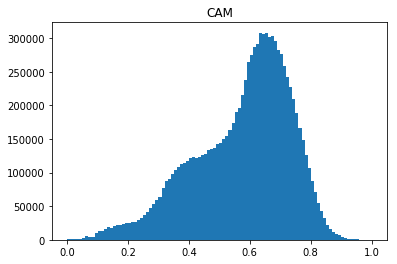

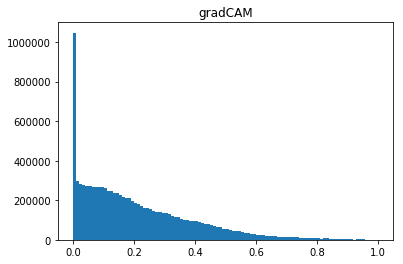

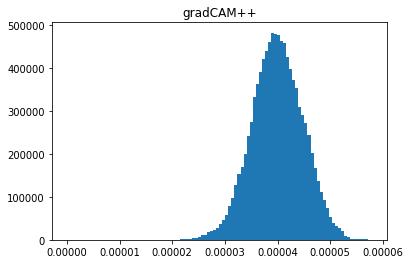

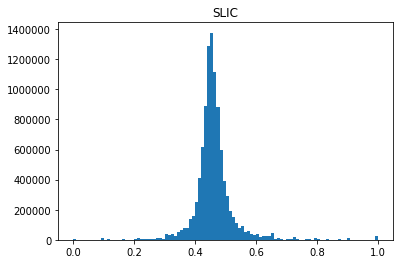

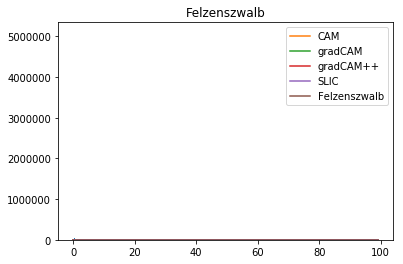

In [35]:
def find_threshold(cum, perc):
    return np.argwhere((np.asarray(cum)>perc)*1==1)[-1][0]

_h = heatmaps_list
methods = ['CAM', 'gradCAM', 'gradCAM++', 'SLIC', 'Felzenszwalb']
concat_heat={'CAM':[], 'gradCAM':[], 'gradCAM++': [],'SLIC':[], 'AVG':[], 'Felzenszwalb': []}
tohist={}

for i in range(len(_h)):
    concat_heat['CAM'].append(normalize_heatmap(_h[i]['CAM'], vmin=vmin_cam, vmax=vmax_cam))
    concat_heat['gradCAM'].append(normalize_heatmap(_h[i]['gradCAM'], vmin=vmin_gradcam, vmax=vmax_gradcam))
    concat_heat['gradCAM++'].append(normalize_heatmap(clip_heatmap(_h[i]['gradCAM++']), vmin=vmin_gradcamplus, vmax=5))
    concat_heat['SLIC'].append(normalize_heatmap(_h[i]['SLIC'], vmin=vmin_slic, vmax=vmax_slic))
    concat_heat['Felzenszwalb'].append(normalize_heatmap(_h[i]['Felzenszwalb'], vmin=vmin_felz, vmax=vmax_felz))
    #concat_heat['gradCAM++'].append(normalize_heatmap(clip_heatmap(_h[i]['gradCAM++']), vmin=vmin_gradcamplus, vmax=5))
    #concat_heat['AVG'].append(normalize_heatmap(_h[i]['AVG'], vmin=vmin_cams, vmax=vmax_cams))

tohist['CAM'] = np.asarray(concat_heat['CAM']).ravel()
tohist['gradCAM'] = np.asarray(concat_heat['gradCAM']).ravel()
tohist['gradCAM++'] = np.asarray(concat_heat['gradCAM++']).ravel()
tohist['SLIC'] = np.asarray(concat_heat['SLIC']).ravel()
tohist['Felzenszwalb'] = np.asarray(concat_heat['Felzenszwalb']).ravel()
#tohist['gradCAM++'] = np.asarray(concat_heat['gradCAM++']).ravel()
#tohist['AVG'] = np.asarray(concat_heat['AVG']).ravel()

histograms={}

#methods = ['CAM', 'gradCAM', 'gradCAM++', 'CAMs']
for method in ['CAM', 'gradCAM', 'gradCAM++', 'SLIC', 'Felzenszwalb']:
    plt.figure()
    #if '++' not in method:
    #histograms[method]=plt.hist(tohist[method], range=(0, np.max(tohist[method])), bins=100)
    #plt.hist(tohist[method], range=(0, np.max(tohist[method])), bins=100, cumulative=True)
    print method
    histograms[method]=plt.hist(tohist[method], range=(0, np.max(tohist[method])), bins=100)
    plt.title(method)
    #else:
    #    histograms[method]=plt.hist((tohist['gradCAM++']), range=(np.min(tohist[method]),2.9), bins=100)
    #    plt.title(method)
for method in methods:
    plt.plot([np.sum(histograms[method][0][i:])/np.sum(histograms[method][0]) for i in range(0,100)])
plt.legend(methods)   
thresholds={'CAM':None, 'gradCAM':None, 'gradCAM++':None,'SLIC':None, 'Felzenszwalb':None}

for method in ['CAM', 'gradCAM', 'gradCAM++', 'SLIC', 'Felzenszwalb']:
    cumulative_=[np.sum(histograms[method][0][i:])/np.sum(histograms[method][0]) for i in range(0,100)]
    i = find_threshold(cumulative_, 0.6)
    print i
    threshold = histograms[method][1][i]
    
    print '{} threshold '.format(method), threshold
    thresholds[method]=threshold

In [36]:
def compute_heatmap_histograms(data_path, heatmaps, vmins=[], vmaxs=[]):
    no_images, no_methods = len(heatmaps), len(heatmaps[0])
    #import pdb; pdb.set_trace()
    print no_images, no_methods
    methods = heatmaps[0].keys()
    methods = sorted(methods, key=lambda method: get_method_num(method))
    figsize = (6.4*no_methods, 4.8*no_images)
    fig, axes = plt.subplots(nrows=no_images, ncols=no_methods, figsize=figsize)
    normalized_heatmaps=[{m:d[m] for m in methods} for d in heatmaps]
    
    for j in range(no_methods):
        method=methods[j]
        axes[j].set_title(method, size='xx-large')
        
        for i in range(no_images):
            axes[j].axis('off')
            if method=='CAM':
                hp=normalized_heatmaps[i]['CAM']=normalize_heatmap(heatmaps[i]['CAM'], vmin=vmins[0], vmax=vmaxs[0])
            elif method=='gradCAM':
                hp=normalized_heatmaps[i]['gradCAM']=normalize_heatmap(heatmaps[i]['gradCAM'], vmin=vmins[1], vmax=vmaxs[1])
            elif method=='gradCAM++':
                hp=normalized_heatmaps[i]['gradCAM++']=normalize_heatmap(heatmaps[i]['gradCAM++'],vmin=vmins[2], vmax=vmaxs[2])
            if 'CAM' in method:
                #plt.figure()
                im=axes[j].hist(hp, bins=10)
    plt.savefig("results/figs/{}/{}".format(EXPERIMENT_TYPE,data_path))
    plt.show()
    
    return normalized_heatmaps

In [37]:
def get_ious(data_path, heatmap, thresholds=None):
    
    path = data_path.split(',')[1].strip(' ')[:-5]
    masks = data['pannuke'][path+'mask'][0]
    image= data['pannuke'][path+'patch'][0]
    #semantic_mask=get_semantic_mask(masks)
    methods=['CAM', 'gradCAM', 'gradCAM++', 'CAMs']
    ious={m:[] for m in methods}
    binary_masks=binarize_all_masks(masks)
    for i in range(6):
        bhp=normalize_heatmap(heatmap['CAM'], vmin=vmin_cam, vmax=vmax_cam)
        bhp=bhp>thresholds['CAM']*1
        ious['CAM'].append(iou(bhp,binary_masks[i]))
        bhp=normalize_heatmap(heatmap['gradCAM'], vmin=vmin_gradcam, vmax=vmax_gradcam)
        bhp=bhp>thresholds['gradCAM']*1
        ious['gradCAM'].append(iou(bhp,binary_masks[i]))
        bhp=normalize_heatmap(heatmap['gradCAM++'], vmin=vmin_gradcamplus, vmax=5)
        bhp=bhp>thresholds['gradCAM++']*1
        ious['gradCAM++'].append(iou(bhp,binary_masks[i]))
        bhp=normalize_heatmap(heatmap['CAMs'], vmin=vmin_cams, vmax=5)
        bhp=bhp>thresholds['CAMs']*1
        ious['CAMs'].append(iou(bhp,binary_masks[i]))
    return ious
        
def iou(bheatmap, mask):
    #import pdb; pdb.set_trace()
    epsilon=2.220446049250313e-16
    #print bheatmap+mask
    intersection=np.float32(np.sum((bheatmap+mask==2)*1))
    return intersection/(np.sum((bheatmap+mask==1)*1)+intersection+epsilon)

In [38]:
def compute_iou(bheatmap, mask):
    #import pdb; pdb.set_trace()
    epsilon=2.220446049250313e-16
    #print bheatmap+mask
    intersection=np.float32(np.sum((bheatmap+mask==2)*1))
    return intersection/(np.sum((bheatmap+mask==1)*1)+intersection+epsilon)

In [46]:
configs={}
['vmaxs']

['vmaxs']

In [47]:
global vmins_dic
vmins_dic={}
global vmaxs_dic
vmaxs_dic={}
vmins_dic['SLIC']=vmin_slic
vmins_dic['Felzenszwalb']=vmin_felz
vmaxs_dic['SLIC']=vmax_slic
vmaxs_dic['Felzenszwalb']=vmax_felz
vmins_dic['CAM']=vmin_cam
vmaxs_dic['CAM']=vmax_cam

vmins_dic['gradCAM']=vmin_gradcam
vmaxs_dic['gradCAM']=vmax_gradcam
vmins_dic['gradCAM++']=vmin_gradcamplus
vmaxs_dic['gradCAM++']=5.

In [48]:
def get_iou(data_path, heatmap, method='CAM', nuclei_type=0, thresholds=None, vmins_dic=None, vmaxs_dic=None):
    path = data_path.split(',')[1].strip(' ')[:-5]
    masks = data['pannuke'][path+'mask'][0]
    image= data['pannuke'][path+'patch'][0]
    binary_masks=binarize_all_masks(masks)
    mask=binary_masks[nuclei_type]
    bhp=None
    #}print method
    if bhp is None:
        #if method != 'gradCAM++':
        bhp=normalize_heatmap(heatmap[method], vmin=vmins_dic[method], vmax=vmaxs_dic[method])
        #else: 
        #    import pdb; pdb.set_trace()
        #    bhp=normalize_heatmap(clip_heatmap(heatmap['gradCAM++'], vmax=5), vmin=vmins_dic[method], vmax=vmaxs_dic[method])
    bhp=(bhp>thresholds[method])*1
    #print method
    #import pdb; pdb.set_trace()
    iou_value=compute_iou(bhp, mask)
    return iou_value

def get_negative_iou(data_path, heatmap, method='CAM', nuclei_type=0, thresholds=None, vmins_dic=None, vmaxs_dic=None):
    path = data_path.split(',')[1].strip(' ')[:-5]
    masks = data['pannuke'][path+'mask'][0]
    image= data['pannuke'][path+'patch'][0]
    binary_masks=binarize_all_masks(masks)
    mask=binary_masks[nuclei_type]
    bhp=None
    rest=np.ones(mask.shape)
    if bhp is None:
        bhp=normalize_heatmap(heatmap[method], vmin=vmins_dic[method], vmax=vmaxs_dic[method])
    bhp=(bhp>thresholds[method])*1
    rest-=mask
    iou_value=compute_iou(bhp, rest)
    return iou_value


def get_all_iou_values(heatmaps_list, methods=methods, max_elements=100, thresholds=thresholds, configs=configs):
    ious_list={m:{i:[] for i in range(6)} for m in methods}
    n_ious_list={m:{i:[] for i in range(6)} for m in methods}
    nucleis_list=[]
    for h in heatmaps_list[:max_elements]:
        for m in methods:
            #print m
            for i in h['nuclei_types']:
                iou_value=get_iou(h['path'], h, method=m, nuclei_type=i, thresholds=thresholds, vmins_dic=vmins_dic, vmaxs_dic=vmaxs_dic)
                negative_iou_value=get_negative_iou(h['path'], h, method=m, nuclei_type=i, thresholds=thresholds, vmins_dic=vmins_dic, vmaxs_dic=vmaxs_dic)
                
                ious_list[m][i].append(iou_value)
                n_ious_list[m][i].append(negative_iou_value)
    return ious_list, n_ious_list
                                

In [49]:
h=heatmaps_tumor_list_pred_ok[9]
get_iou(h['path'], h, method='gradCAM++', nuclei_type=0, thresholds=thresholds, vmins_dic=vmins_dic, vmaxs_dic=vmaxs_dic)

0.1397447055410502

In [50]:
#adding nuclei_types info
image_lists={i:[] for i in range(6)}
for d in heatmaps_list:
    d['nuclei_types']=[]
idx=0
for d in heatmaps_list:
    #print d['path']
    path = d['path'].split(',')[1].strip(' ')[:-5]
    masks = data['pannuke'][path+'mask'][0]
    #image= data['pannuke'][path+'patch'][0]
    #semantic_mask=get_semantic_mask(masks)
    binary_masks=binarize_all_masks(masks)
    for i in range(6):
        if np.sum(binary_masks[i])>0: 
            d['nuclei_types'].append(i)
    idx+=1

In [51]:
#ious_normal_ok,n_ious_normal_ok = get_all_iou_values(heatmaps_normal_list_pred_ok)
#ious_normal_ok,n_ious_normal_ok = get_all_iou_values(heatmaps_normal_list_pred_ko)
ious_tumor_ok,n_ious_tumor_ok = get_all_iou_values(heatmaps_tumor_list_pred_ok)
ious_tumor_ko,n_ious_tumor_ko = get_all_iou_values(heatmaps_tumor_list_pred_ko)

In [52]:
np.save('results/RANDOM_ious_tp_fn', [ious_tumor_ok,ious_tumor_ko])

In [338]:
len(heatmaps_tumor_list_pred_ok)

57

In [53]:
dic={}
#for i in range(6):
#    dic['{}'.format(i)]=[]
dic['iou']=[]
dic['nuclei_type']=[]
dic['method']=[]
dic['class']=[]
#dic['path']=[]

methods= ['gradCAM++',
 'gradCAM',
 'CAM','SLIC', 'Felzenszwalb']

for m in methods:
    print m
    for k in range(5):
        #print k
        if ious_tumor_ok[m][k] != []:
            for el in range(len(ious_tumor_ok[m][k])):
                #print 'nuclei_type ', k, ious_tumor_ok[m][k][el]
                dic['nuclei_type'].append(k)
                dic['iou'].append(ious_tumor_ok[m][k][el])
                dic['method'].append(m)
                dic['class'].append('TP')
for m in methods:
    print m
    for k in range(5):
        #print k
        if ious_tumor_ko[m][k] != []:
            for el in range(len(ious_tumor_ko[m][k])):
                #print 'nuclei_type ', k, ious_tumor_ok[m][k][el]
                dic['nuclei_type'].append(k)
                dic['iou'].append(ious_tumor_ko[m][k][el])
                dic['method'].append(m)
                dic['class'].append('FN')
            
       

gradCAM++
gradCAM
CAM
SLIC
Felzenszwalb
gradCAM++
gradCAM
CAM
SLIC
Felzenszwalb


In [54]:
import pandas as pd
ious_df=pd.DataFrame(dic)

In [55]:
np.sum([(d==4)*1 for d in dic['nuclei_type']])

5

Text(0,0.5,u'IOU')

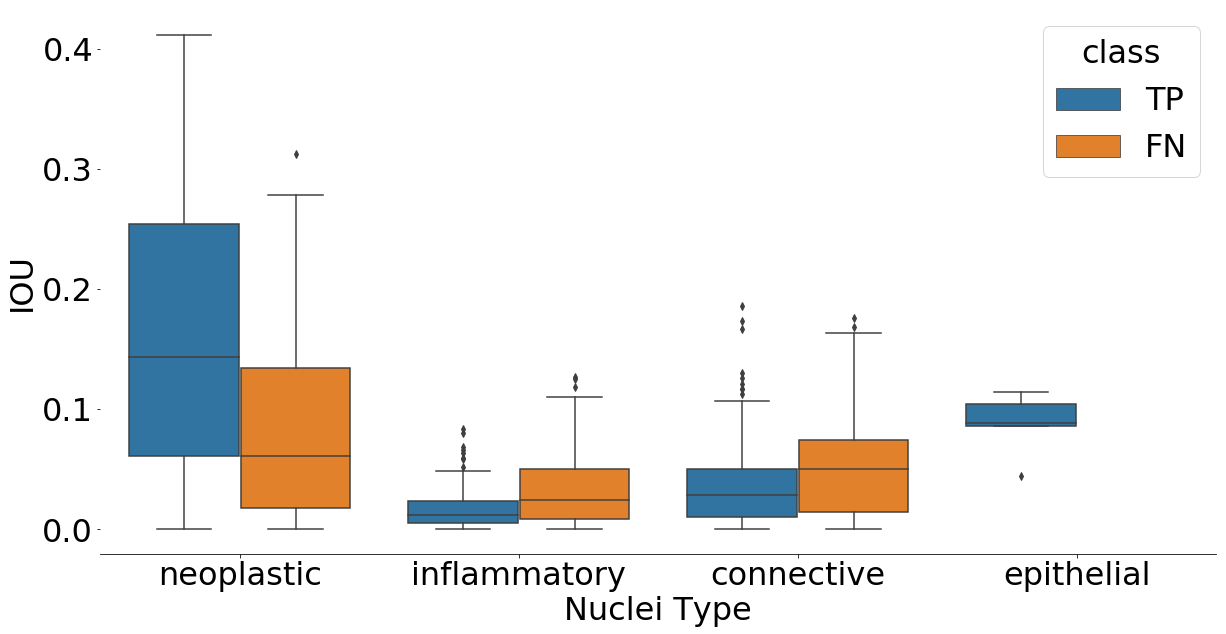

In [56]:
plt.rcParams['figure.figsize']=(20,10)
plt.rcParams['font.size']=32

import seaborn as sns
g=sns.boxplot(data=ious_df, x="nuclei_type", y='iou', hue='class')#, orient="h")#,
               #split=True)#,cut=0) #inner="quart", linewidth=1,)
               #palette={"Yes": "b", "No": ".85"})
#
sns.despine(left=True)
g.set_xticks(range(4)) # <--- set the ticks first
g.set_xticklabels(['neoplastic', 'inflammatory', 'connective', 'epithelial'])
g.set_xlabel('Nuclei Type')
g.set_ylabel('IOU')

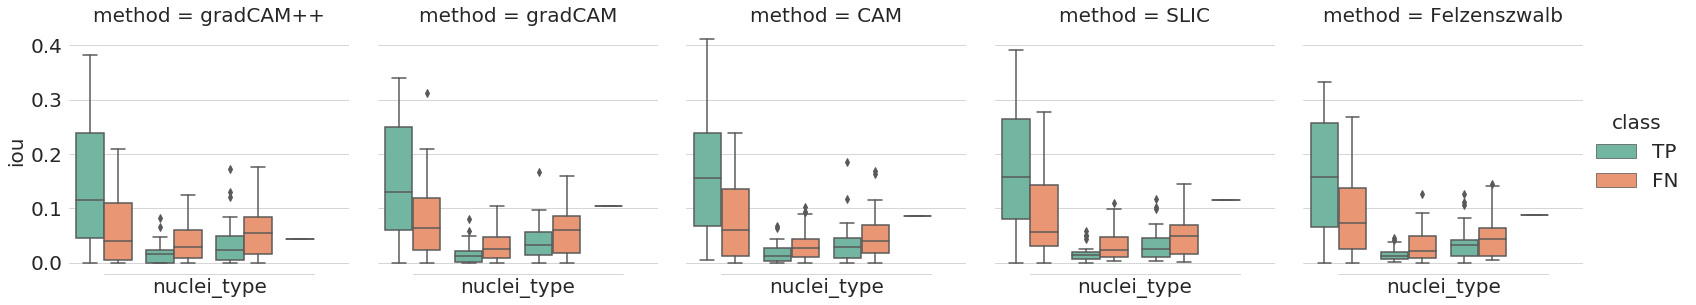

In [57]:
plt.rcParams['figure.figsize']=(20,10)
plt.rcParams['font.size']=20

import seaborn as sns
sns.set_style('whitegrid')
g=sns.catplot(data=ious_df, x="nuclei_type", y='iou', hue='class', col='method', 
              kind='box',
              palette="Set2", aspect=.9)
#

sns.despine(left=True, trim=True)



#g.set_xticks(range(4)) # <--- set the ticks first
#g.set_xticklabels(['neoplastic', 'inflammatory', 'connective', 'epithelial'])
#g.set_xlabel('Nuclei Type')
#catplot set ticks
g.set(xticks=[])
#g.set_ylabel('IOU')

In [84]:
#plt.imshow(heatmaps_tumor_list_pred_ok[0]['CAM'])
heatmaps_tumor_list_pred_ok[0]['path']

'pannuke, pannuke/fold3/856/tumor/upper_left/patch, 0, train\n'

In [81]:
hcorrect=np.load('./results/unbiased_iou_pannuke/FINAL_ALL_HM_LIST.npy')

In [83]:
#plt.imshow(hcorrect[_idx_heatmaps_tumor_list_pred_ok[0]]['CAM'])
hcorrect[_idx_heatmaps_tumor_list_pred_ok[0]]['path']

'pannuke, pannuke/fold3/856/tumor/upper_left/patch, 0, train\n'

In [64]:
np.save('results/iou_dic',dic)

In [62]:
dic['niou']=[]

methods= ['gradCAM++',
 'gradCAM',
 'CAM','SLIC', 'Felzenszwalb']

for m in methods:
    print m
    for k in range(5):
        #print k
        if ious_tumor_ok[m][k] != []:
            for el in range(len(n_ious_tumor_ok[m][k])):
                #print 'nuclei_type ', k, ious_tumor_ok[m][k][el]
                #dic['nuclei_type'].append(k)
                dic['niou'].append(n_ious_tumor_ok[m][k][el])
                #dic['method'].append(m)
                #dic['class'].append('TP')
for m in methods:
    print m
    for k in range(5):
        #print k
        if ious_tumor_ko[m][k] != []:
            for el in range(len(n_ious_tumor_ko[m][k])):
                #print 'nuclei_type ', k, ious_tumor_ok[m][k][el]
                #dic['nuclei_type'].append(k)
                dic['niou'].append(n_ious_tumor_ko[m][k][el])
                #dic['method'].append(m)
                #dic['class'].append('FN')
            
ious_df=pd.DataFrame(dic)       

gradCAM++
gradCAM
CAM
SLIC
Felzenszwalb
gradCAM++
gradCAM
CAM
SLIC
Felzenszwalb


In [355]:
dic['uiou']=[]

methods= ['gradCAM++',
 'gradCAM',
 'CAM','SLIC', 'Felzenszwalb']

for m in methods:
    print m
    for k in range(5):
        #print k
        if ious_tumor_ok[m][k] != []:
            for el in range(len(n_ious_tumor_ok[m][k])):
                #print 'nuclei_type ', k, ious_tumor_ok[m][k][el]
                #dic['nuclei_type'].append(k)
                dic['uiou'].append(n_ious_tumor_ok[m][k][el]+ious_tumor_ok[m][k][el])
                #dic['method'].append(m)
                #dic['class'].append('TP')
for m in methods:
    print m
    for k in range(5):
        #print k
        if ious_tumor_ko[m][k] != []:
            for el in range(len(n_ious_tumor_ko[m][k])):
                #print 'nuclei_type ', k, ious_tumor_ok[m][k][el]
                #dic['nuclei_type'].append(k)
                dic['uiou'].append(n_ious_tumor_ko[m][k][el]+ious_tumor_ko[m][k][el])
                #dic['method'].append(m)
                #dic['class'].append('FN')
            
ious_df=pd.DataFrame(dic)       

gradCAM++
gradCAM
CAM
SLIC
Felzenszwalb
gradCAM++
gradCAM
CAM
SLIC
Felzenszwalb



### Structural Similarity SSIM between CAM and gradCAM

In [ ]:
import heatmaps_utils
reload (heatmaps_utils)
from heatmaps_utils import *

In [165]:
heatmaps_list=np.load('results/unbiased_iou_pannuke/FINAL_ALL_HM_LIST.npy')

In [166]:
len(heatmaps_list)

198

In [167]:
for th in [0.875]:
    heatmaps_normal_list = [d for d in heatmaps_list if d['type'] == 'normal']
    heatmaps_tumor_list = [d for d in heatmaps_list if d['type'] == 'tumor']

    _idx_heatmaps_normal_list_pred_ok = [idx for idx in range(len(heatmaps_list)) if heatmaps_list[idx]['type'] == 'normal' and heatmaps_list[idx]['pred'] < th]
    _idx_heatmaps_tumor_list_pred_ok = [idx for idx in range(len(heatmaps_list)) if heatmaps_list[idx]['type'] == 'tumor' and heatmaps_list[idx]['pred'] >= th]
    _idx_heatmaps_normal_list_pred_ko = [idx for idx in range(len(heatmaps_list)) if heatmaps_list[idx]['type']== 'normal' and heatmaps_list[idx]['pred'] >= th]
    _idx_heatmaps_tumor_list_pred_ko = [idx for idx in range(len(heatmaps_list)) if heatmaps_list[idx]['type'] == 'tumor' and heatmaps_list[idx]['pred'] < th]
    print th, len(heatmaps_tumor_list_pred_ok), len(heatmaps_tumor_list_pred_ko), len(heatmaps_normal_list_pred_ko),len(heatmaps_normal_list_pred_ok)
    print 'th: {}, misclassified: '.format(th), len(heatmaps_tumor_list_pred_ko)+ len(heatmaps_normal_list_pred_ko)

0.875 59 41 14 84
th: 0.875, misclassified:  55


In [126]:
heatmaps_normal_list_pred_ok = [heatmaps_list[idx] for idx in _idx_heatmaps_normal_list_pred_ok]
heatmaps_tumor_list_pred_ok = [heatmaps_list[idx] for idx in _idx_heatmaps_tumor_list_pred_ok]
heatmaps_normal_list_pred_ko = [heatmaps_list[idx] for idx in _idx_heatmaps_normal_list_pred_ko]
heatmaps_tumor_list_pred_ko = [heatmaps_list[idx] for idx in _idx_heatmaps_tumor_list_pred_ko]


In [87]:
prop = 0.8
h = copy.deepcopy(heatmaps_list)
np.random.shuffle(h)
h = [_h for _h in h ]#if not np.isnan(np.sum(_h['gradCAM']))]
n = int(prop*len(h))
train_list = h[:n]
test_list = h[n:]

In [88]:
configs['vmins']

[-4.604314, 0, 0, -0.1543001425410845, -0.10938516930367083]

In [128]:
global vmins_dic
vmins_dic={}
global vmaxs_dic
vmaxs_dic={}
vmins_dic['SLIC']=vmin_slic
vmins_dic['Felzenszwalb']=vmin_felz
vmaxs_dic['SLIC']=vmax_slic
vmaxs_dic['Felzenszwalb']=vmax_felz
vmins_dic['CAM']=vmin_cam
vmaxs_dic['CAM']=vmax_cam
vmins_dic['gradCAM']=vmin_gradcam
vmaxs_dic['gradCAM']=vmax_gradcam
vmins_dic['gradCAM++']=vmin_gradcamplus
vmaxs_dic['gradCAM++']=vmax_gradcamplus

pannuke/fold3/560/normal/upper_right/


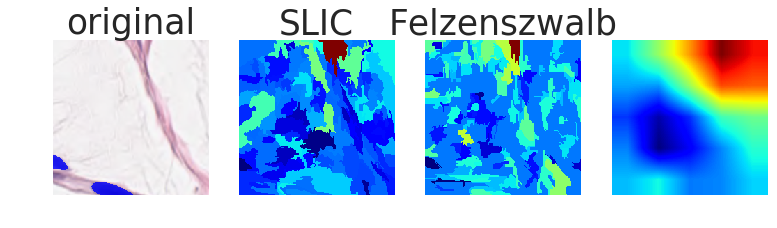

In [153]:
img_idx=25
alpha=0.8
figsize = (12.8, 4.8)
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=figsize)
axes[0].set_title('original', size='xx-large')
axes[1].set_title('SLIC', size='xx-large')
axes[2].set_title('Felzenszwalb', size='xx-large')
#axes[3].set_title('Quickshift', size='xx-large')
#axes[3].set_title('AVG', size='xx-large')

path = heatmaps_list[img_idx]['path'].split(', ')[1][:-5]
print path
masks = data['pannuke'][path+'mask'][0]
img = np.asarray(data['pannuke'][path+'patch'][0], dtype=np.uint8)
binary_masks = binarize_all_masks(masks)

#axes[i, j].imshow(np.asarray(heatmaps[i]['original'], dtype=np.uint8))
axes[0].imshow(np.asarray(heatmaps_list[img_idx]['original'],dtype=np.uint8))
axes[0].imshow(np.ma.masked_where(binary_masks[0]==0, binary_masks[0]), alpha=alpha, cmap=neoplastic, norm=norm)
axes[0].imshow(np.ma.masked_where(binary_masks[1]==0, binary_masks[1]), alpha=alpha, cmap=inflammatory, norm=norm)
axes[0].imshow(np.ma.masked_where(binary_masks[2]==0, binary_masks[2]), alpha=alpha, cmap=connective, norm=norm)
axes[0].imshow(np.ma.masked_where(binary_masks[3]==0, binary_masks[3]), alpha=alpha, cmap=dead, norm=norm)
axes[0].imshow(np.ma.masked_where(binary_masks[4]==0, binary_masks[4]), alpha=alpha, cmap=epithelial, norm=norm)

axes[1].imshow(heatmaps_list[img_idx]['SLIC'], cmap='jet')
axes[2].imshow(heatmaps_list[img_idx]['Felzenszwalb'], cmap='jet')
axes[3].imshow(heatmaps_list[img_idx]['CAM'], cmap='jet')

#axes[3].imshow(heatmaps_list[img_idx]['AVG'], cmap='jet')

for i in range(4):
    axes[i].axis('off')
plt.show()


In [100]:
##SSIM between CAM and gradCAM
def compute_ssim(heatmaps, method1, method2, vmins={}, vmaxs={}):
    
    h1 = normalize_heatmap(np.asarray(heatmaps[method1], dtype=np.float64), vmin=vmins[method1], vmax=vmaxs[method1])
    h2 = normalize_heatmap(np.asarray(heatmaps[method2], dtype=np.float64), vmin=vmins[method2], vmax=vmaxs[method2])
    return ssim(h1, h2)

def compute_ssims_stats(heatmaps_list, max_=2, method1='SLIC', method2='Felzenszwalb'):
    preds=[]
    ssims = []
    
    for heatmaps in heatmaps_list[:max_]:
        #print heatmaps['path']
        #print 'pred:', heatmaps['pred']
        try:
            #auprcs, thresholds = auprc_heatmaps(heatmaps, method1, method2)
            _ssim = compute_ssim(heatmaps, method1, method2, vmins_dic, vmaxs_dic)
            preds.append(heatmaps['pred'])
            ssims.append(_ssim)
            #print 'SSIM: ', _ssim
            #for _auprc, threshold in zip(auprcs, thresholds):
            #    print round(threshold, 3), _auprc
        except Exception as e:
            print e
        #print '\n\n'
    #print 'Avg SSIMS: ', np.mean(ssims), np.std(ssims)
    return ssims, preds

def compute_ssims_stats_hmlists(heatmaps_list1, hmlist2, method, max_=2):
    preds=[]
    ssims = []
    
    for heatmaps in heatmaps_list[:max_]:
        #print heatmaps['path']
        #print 'pred:', heatmaps['pred']
        try:
            #auprcs, thresholds = auprc_heatmaps(heatmaps, method1, method2)
            _ssim = compute_ssim(heatmaps_list1, hmlist2, method, vmins_dic, vmaxs_dic)
            preds.append(heatmaps['pred'])
            ssims.append(_ssim)
            #print 'SSIM: ', _ssim
            #for _auprc, threshold in zip(auprcs, thresholds):
            #    print round(threshold, 3), _auprc
        except Exception as e:
            print e
        #print '\n\n'
    #print 'Avg SSIMS: ', np.mean(ssims), np.std(ssims)
    return ssims, preds


In [129]:
ssims, preds = compute_ssims_stats(heatmaps_normal_list_pred_ok, max_=200)
print "TN (0, 0): {} ({})".format(np.mean(ssims), np.std(ssims))
ssims, preds = compute_ssims_stats(heatmaps_normal_list_pred_ko, max_=200)
print "FP (0, 1): {} ({})".format(np.mean(ssims), np.std(ssims))
ssims, preds = compute_ssims_stats(heatmaps_tumor_list_pred_ok, max_=200)
print "TP (1, 1): {} ({})".format(np.mean(ssims), np.std(ssims))
ssims, preds = compute_ssims_stats(heatmaps_tumor_list_pred_ko, max_=200)
print "FN (1, 0): {} ({})".format(np.mean(ssims), np.std(ssims))

TN (0, 0): 0.605413830055 (0.0808968391071)
FP (0, 1): 0.618176624288 (0.0436041257498)
TP (1, 1): 0.555490127685 (0.0891367434879)
FN (1, 0): 0.648921287039 (0.0561416584884)


In [138]:
## btween ssim and prediction when we use cam and gradcam
# there seems to be a linear correlation between the ssim of cam/gradcam and the prediction
# high ssim if prediction is high (close to 1= tumor class)... same stuff seems to be highlighted in tumor images? check with visualiz. 
# ADD check of correctness of prediction
import statsmodels.api as sm

def linear_regression(y, X, random_state=1234, verbose=0, summary=False):
    X = sm.add_constant(X) # Add constant term
    model = sm.OLS(y, X).fit()
    if summary:
        print model.summary()
    return model

y = np.array(preds, dtype=np.float64)
X = np.array(ssims, dtype=np.float64)
lr = linear_regression(y, X)


test_pred = [heatmaps['pred'] for heatmaps in test_list]
test_ssims = [compute_ssim(heatmaps, 'SLIC', 'Felzenszwalb', vmins_dic, vmaxs_dic) for heatmaps in test_list]


X = np.array(test_pred, dtype=np.float64)
X = sm.add_constant(X) # Add constant term
params = lr.params
test_ssims_pred = np.dot(X, np.array(params))

SSE = np.sum(np.square(np.subtract(test_ssims, test_ssims_pred)))
MSE = SSE/len(test_ssims)
TSS = np.sum(np.square(np.subtract(test_ssims, np.mean(test_ssims))))
R2 = 1 - (SSE/TSS)
print MSE, R2, lr.params

from scipy.stats import pearsonr

y = np.array(preds, dtype=np.float64)
X = np.array(ssims, dtype=np.float64)
print X.shape, y.shape, pearsonr(X,y[:,0])

0.043028758321648396 -4.4331114225671495 5.4331114225671495 [0.76547713 0.00461217]


(53,) (53, 1) (0.0032919061407644533, 0.9813359709430358)



### Structural Similarity SSIM between CAM and LIME (10 features retained)

In [95]:
import heatmaps_utils
reload (heatmaps_utils)
from heatmaps_utils import *

In [96]:
##SSIM between CAM and gradCAM
def compute_ssim(heatmaps, method1, method2, vmins={}, vmaxs={}):
    
    h1 = normalize_heatmap(np.asarray(heatmaps[method1], dtype=np.float64), vmin=vmins[method1], vmax=vmaxs[method1])
    h2 = normalize_heatmap(np.asarray(heatmaps[method2], dtype=np.float64), vmin=vmins[method2], vmax=vmaxs[method2])
    return ssim(h1, h2)

def compute_ssims_stats(heatmaps_list, max_=2, method1='SLIC', method2='Felzenszwalb'):
    preds=[]
    ssims = []
    
    for heatmaps in heatmaps_list[:max_]:
        #print heatmaps['path']
        #print 'pred:', heatmaps['pred']
        try:
            #auprcs, thresholds = auprc_heatmaps(heatmaps, method1, method2)
            _ssim = compute_ssim(heatmaps, method1, method2, vmins_dic, vmaxs_dic)
            preds.append(heatmaps['pred'])
            ssims.append(_ssim)
            #print 'SSIM: ', _ssim
            #for _auprc, threshold in zip(auprcs, thresholds):
            #    print round(threshold, 3), _auprc
        except Exception as e:
            print e
        #print '\n\n'
    #print 'Avg SSIMS: ', np.mean(ssims), np.std(ssims)
    return ssims, preds

In [114]:
heatmaps_normal_list_pred_ko

[]

In [140]:
ssims, preds = compute_ssims_stats(heatmaps_normal_list_pred_ok, method1='CAM', method2='gradCAM',max_=200)
print "TN (0, 0): {} ({})".format(np.mean(ssims), np.std(ssims))
ssims, preds = compute_ssims_stats(heatmaps_tumor_list_pred_ok, method1='CAM', method2='gradCAM',max_=200)
print "TP (1, 1): {} ({})".format(np.mean(ssims), np.std(ssims))
ssims, preds = compute_ssims_stats(heatmaps_tumor_list_pred_ko,method1='CAM', method2='gradCAM', max_=200)
print "FN (1, 0): {} ({})".format(np.mean(ssims), np.std(ssims))
ssims, preds = compute_ssims_stats(heatmaps_normal_list_pred_ko,method1='CAM', method2='gradCAM', max_=200)
print "FP (0, 1): {} ({})".format(np.mean(ssims), np.std(ssims))


TN (0, 0): 0.88811200833 (0.132478567243)
TP (1, 1): 0.891612695049 (0.0524190668652)
FN (1, 0): 0.909998396511 (0.0741277648472)
FP (0, 1): 0.934433422229 (0.023105869475)


In [ ]:
TN (0, 0): 0.88811200833 (0.132478567243)
TP (1, 1): 0.891612695049 (0.0524190668652)
FN (1, 0): 0.909998396511 (0.0741277648472)
FP (0, 1): 0.934433422229 (0.023105869475)

In [131]:
ssims, preds = compute_ssims_stats(heatmaps_normal_list_pred_ok, method1='CAM', method2='gradCAM++',max_=200)
print "TN (0, 0): {} ({})".format(np.mean(ssims), np.std(ssims))
ssims, preds = compute_ssims_stats(heatmaps_normal_list_pred_ko,method1='CAM', method2='gradCAM++', max_=200)
print "FP (0, 1): {} ({})".format(np.mean(ssims), np.std(ssims))
ssims, preds = compute_ssims_stats(heatmaps_tumor_list_pred_ok, method1='CAM', method2='gradCAM++',max_=200)
print "TP (1, 1): {} ({})".format(np.mean(ssims), np.std(ssims))
ssims, preds = compute_ssims_stats(heatmaps_tumor_list_pred_ko,method1='CAM', method2='gradCAM++', max_=200)
print "FN (1, 0): {} ({})".format(np.mean(ssims), np.std(ssims))

TN (0, 0): 0.860754772093 (0.104938275855)
FP (0, 1): 0.469821132897 (0.151214231721)
TP (1, 1): 0.349484558094 (0.221870506296)
FN (1, 0): 0.841126863167 (0.094244791928)


In [ ]:
TN (0, 0): 0.860754772093 (0.104938275855)
TP (1, 1): 0.349484558094 (0.221870506296)
FN (1, 0): 0.841126863167 (0.094244791928)
FP (0, 1): 0.469821132897 (0.151214231721)

In [132]:
ssims, preds = compute_ssims_stats(heatmaps_normal_list_pred_ok, method1='gradCAM', method2='gradCAM++',max_=200)
print "TN (0, 0): {} ({})".format(np.mean(ssims), np.std(ssims))
ssims, preds = compute_ssims_stats(heatmaps_normal_list_pred_ko,method1='gradCAM', method2='gradCAM++', max_=200)
print "FP (0, 1): {} ({})".format(np.mean(ssims), np.std(ssims))
ssims, preds = compute_ssims_stats(heatmaps_tumor_list_pred_ok, method1='gradCAM', method2='gradCAM++',max_=200)
print "TP (1, 1): {} ({})".format(np.mean(ssims), np.std(ssims))
ssims, preds = compute_ssims_stats(heatmaps_tumor_list_pred_ko,method1='gradCAM', method2='gradCAM++', max_=200)
print "FN (1, 0): {} ({})".format(np.mean(ssims), np.std(ssims))

TN (0, 0): 0.862406936392 (0.0968421280428)
FP (0, 1): 0.599599660373 (0.139235259248)
TP (1, 1): 0.473765212111 (0.245190834819)
FN (1, 0): 0.842853578383 (0.0823752313018)


In [ ]:
TN (0, 0): 0.862406936392 (0.0968421280428)
TP (1, 1): 0.473765212111 (0.245190834819)
FN (1, 0): 0.842853578383 (0.0823752313018)
FP (0, 1): 0.599599660373 (0.139235259248)

In [133]:
ssims, preds = compute_ssims_stats(heatmaps_normal_list_pred_ok, method1='Felzenszwalb', method2='SLIC',max_=200)
print "TN (0, 0): {} ({})".format(np.mean(ssims), np.std(ssims))
ssims, preds = compute_ssims_stats(heatmaps_normal_list_pred_ko,method1='Felzenszwalb', method2='SLIC', max_=200)
print "FP (0, 1): {} ({})".format(np.mean(ssims), np.std(ssims))
ssims, preds = compute_ssims_stats(heatmaps_tumor_list_pred_ok, method1='Felzenszwalb', method2='SLIC',max_=200)
print "TP (1, 1): {} ({})".format(np.mean(ssims), np.std(ssims))
ssims, preds = compute_ssims_stats(heatmaps_tumor_list_pred_ko,method1='Felzenszwalb', method2='SLIC', max_=200)
print "FN (1, 0): {} ({})".format(np.mean(ssims), np.std(ssims))

TN (0, 0): 0.605413830055 (0.0808968391071)
FP (0, 1): 0.618176624288 (0.0436041257498)
TP (1, 1): 0.555490127685 (0.0891367434879)
FN (1, 0): 0.648921287039 (0.0561416584884)


In [ ]:
TN (0, 0): 0.605413830055 (0.0808968391071)
TP (1, 1): 0.555490127685 (0.0891367434879)
FN (1, 0): 0.648921287039 (0.0561416584884)
FP (0, 1): 0.618176624288 (0.0436041257498)

In [134]:
ssims, preds = compute_ssims_stats(heatmaps_normal_list_pred_ok, method1='CAM', method2='SLIC',max_=200)
print "TN (0, 0): {} ({})".format(np.mean(ssims), np.std(ssims))
ssims, preds = compute_ssims_stats(heatmaps_normal_list_pred_ko,method1='CAM', method2='SLIC', max_=200)
print "FP (0, 1): {} ({})".format(np.mean(ssims), np.std(ssims))
ssims, preds = compute_ssims_stats(heatmaps_tumor_list_pred_ok, method1='CAM', method2='SLIC',max_=200)
print "TP (1, 1): {} ({})".format(np.mean(ssims), np.std(ssims))
ssims, preds = compute_ssims_stats(heatmaps_tumor_list_pred_ko,method1='CAM', method2='SLIC', max_=200)
print "FN (1, 0): {} ({})".format(np.mean(ssims), np.std(ssims))

TN (0, 0): 0.772239278984 (0.0824175719346)
FP (0, 1): 0.828620206052 (0.0480749532564)
TP (1, 1): 0.752807818342 (0.111055317235)
FN (1, 0): 0.820823736308 (0.0554179087767)


In [ ]:
TN (0, 0): 0.772239278984 (0.0824175719346)
TP (1, 1): 0.752807818342 (0.111055317235)
FN (1, 0): 0.820823736308 (0.0554179087767)
FP (0, 1): 0.828620206052 (0.0480749532564)

In [135]:
ssims, preds = compute_ssims_stats(heatmaps_normal_list_pred_ok, method1='gradCAM', method2='SLIC',max_=200)
print "TN (0, 0): {} ({})".format(np.mean(ssims), np.std(ssims))
ssims, preds = compute_ssims_stats(heatmaps_normal_list_pred_ko,method1='gradCAM', method2='SLIC', max_=200)
print "FP (0, 1): {} ({})".format(np.mean(ssims), np.std(ssims))
ssims, preds = compute_ssims_stats(heatmaps_tumor_list_pred_ok, method1='gradCAM', method2='SLIC',max_=200)
print "TP (1, 1): {} ({})".format(np.mean(ssims), np.std(ssims))
ssims, preds = compute_ssims_stats(heatmaps_tumor_list_pred_ko,method1='gradCAM', method2='SLIC', max_=200)
print "FN (1, 0): {} ({})".format(np.mean(ssims), np.std(ssims))

TN (0, 0): 0.658736124041 (0.149066806339)
FP (0, 1): 0.737574322326 (0.0621275319707)
TP (1, 1): 0.64457804856 (0.109098369803)
FN (1, 0): 0.722910080737 (0.109828009544)


In [ ]:
TN (0, 0): 0.658736124041 (0.149066806339)
TP (1, 1): 0.64457804856 (0.109098369803)
FN (1, 0): 0.722910080737 (0.109828009544)
FP (0, 1): 0.737574322326 (0.0621275319707)

In [136]:
ssims, preds = compute_ssims_stats(heatmaps_normal_list_pred_ok, method1='gradCAM++', method2='SLIC',max_=200)
print "TN (0, 0): {} ({})".format(np.mean(ssims), np.std(ssims))
ssims, preds = compute_ssims_stats(heatmaps_normal_list_pred_ko,method1='gradCAM++', method2='SLIC', max_=200)
print "FP (0, 1): {} ({})".format(np.mean(ssims), np.std(ssims))
ssims, preds = compute_ssims_stats(heatmaps_tumor_list_pred_ok, method1='gradCAM++', method2='SLIC',max_=200)
print "TP (1, 1): {} ({})".format(np.mean(ssims), np.std(ssims))
ssims, preds = compute_ssims_stats(heatmaps_tumor_list_pred_ko,method1='gradCAM++', method2='SLIC', max_=200)
print "FN (1, 0): {} ({})".format(np.mean(ssims), np.std(ssims))

TN (0, 0): 0.652699330865 (0.144223787098)
FP (0, 1): 0.373327426997 (0.132290758448)
TP (1, 1): 0.28684766156 (0.187768714327)
FN (1, 0): 0.701335795897 (0.104247960166)


In [ ]:
TN (0, 0): 0.652699330865 (0.144223787098)
TP (1, 1): 0.28684766156 (0.187768714327)
FN (1, 0): 0.701335795897 (0.104247960166)
FP (0, 1): 0.373327426997 (0.132290758448)

In [137]:
ssims, preds = compute_ssims_stats(heatmaps_normal_list_pred_ok, method1='Felzenszwalb', method2='CAM',max_=200)
print "TN (0, 0): {} ({})".format(np.mean(ssims), np.std(ssims))
ssims, preds = compute_ssims_stats(heatmaps_normal_list_pred_ko,method1='Felzenszwalb', method2='CAM', max_=200)
print "FP (0, 1): {} ({})".format(np.mean(ssims), np.std(ssims))
ssims, preds = compute_ssims_stats(heatmaps_tumor_list_pred_ok, method1='Felzenszwalb', method2='CAM',max_=200)
print "TP (1, 1): {} ({})".format(np.mean(ssims), np.std(ssims))
ssims, preds = compute_ssims_stats(heatmaps_tumor_list_pred_ko,method1='Felzenszwalb', method2='CAM', max_=200)
print "FN (1, 0): {} ({})".format(np.mean(ssims), np.std(ssims))

TN (0, 0): 0.692365672817 (0.054578044897)
FP (0, 1): 0.683416646506 (0.0357879962237)
TP (1, 1): 0.66097144101 (0.0470721381428)
FN (1, 0): 0.713664911802 (0.0408759605165)


In [ ]:
TN (0, 0): 0.692365672817 (0.054578044897)
TP (1, 1): 0.66097144101 (0.0470721381428)
FN (1, 0): 0.713664911802 (0.0408759605165)
FP (0, 1): 0.683416646506 (0.0357879962237)


In [138]:
ssims, preds = compute_ssims_stats(heatmaps_normal_list_pred_ok, method1='Felzenszwalb', method2='gradCAM',max_=200)
print "TN (0, 0): {} ({})".format(np.mean(ssims), np.std(ssims))
ssims, preds = compute_ssims_stats(heatmaps_normal_list_pred_ko,method1='Felzenszwalb', method2='gradCAM', max_=200)
print "FP (0, 1): {} ({})".format(np.mean(ssims), np.std(ssims))
ssims, preds = compute_ssims_stats(heatmaps_tumor_list_pred_ok, method1='Felzenszwalb', method2='gradCAM',max_=200)
print "TP (1, 1): {} ({})".format(np.mean(ssims), np.std(ssims))
ssims, preds = compute_ssims_stats(heatmaps_tumor_list_pred_ko,method1='Felzenszwalb', method2='gradCAM', max_=200)
print "FN (1, 0): {} ({})".format(np.mean(ssims), np.std(ssims))

TN (0, 0): 0.589681842314 (0.112374187816)
FP (0, 1): 0.598867827956 (0.0479294319047)
TP (1, 1): 0.547921236326 (0.0783977610791)
FN (1, 0): 0.624868754527 (0.0779718183285)


In [ ]:
TN (0, 0): 0.589681842314 (0.112374187816)
TP (1, 1): 0.547921236326 (0.0783977610791)
FN (1, 0): 0.624868754527 (0.0779718183285)
FP (0, 1): 0.598867827956 (0.0479294319047)


In [139]:
ssims, preds = compute_ssims_stats(heatmaps_normal_list_pred_ok, method1='Felzenszwalb', method2='gradCAM++',max_=200)
print "TN (0, 0): {} ({})".format(np.mean(ssims), np.std(ssims))
ssims, preds = compute_ssims_stats(heatmaps_normal_list_pred_ko,method1='Felzenszwalb', method2='gradCAM++', max_=200)
print "FP (0, 1): {} ({})".format(np.mean(ssims), np.std(ssims))
ssims, preds = compute_ssims_stats(heatmaps_tumor_list_pred_ok, method1='Felzenszwalb', method2='gradCAM++',max_=200)
print "TP (1, 1): {} ({})".format(np.mean(ssims), np.std(ssims))
ssims, preds = compute_ssims_stats(heatmaps_tumor_list_pred_ko,method1='Felzenszwalb', method2='gradCAM++', max_=200)
print "FN (1, 0): {} ({})".format(np.mean(ssims), np.std(ssims))

TN (0, 0): 0.579839546523 (0.105932456383)
FP (0, 1): 0.294787876819 (0.108932249468)
TP (1, 1): 0.228531585681 (0.154161214577)
FN (1, 0): 0.602327868088 (0.0868525128322)


In [ ]:
TN (0, 0): 0.579839546523 (0.105932456383)
TP (1, 1): 0.228531585681 (0.154161214577)
FN (1, 0): 0.602327868088 (0.0868525128322)
FP (0, 1): 0.294787876819 (0.108932249468)


In [198]:
## btween ssim and prediction when we use cam and gradcam
# there seems to be a linear correlation between the ssim of cam/gradcam and the prediction
# high ssim if prediction is high (close to 1= tumor class)... same stuff seems to be highlighted in tumor images? check with visualiz. 
# ADD check of correctness of prediction
import statsmodels.api as sm
data={}
def linear_regression(y, X, random_state=1234, verbose=0, summary=True):
    X = sm.add_constant(X) # Add constant term
    model = sm.OLS(y, X).fit()
    if summary:
        print model.summary()
    return model
from scipy.stats import pearsonr
for method in methods:
    for method2 in methods:
        #print method, method2
        test_pred = [heatmaps['pred'] for heatmaps in heatmaps_list]
        test_ssims = [compute_ssim(heatmaps, method, method2, vmins_dic, vmaxs_dic) for heatmaps in heatmaps_list]
        ssims, preds = compute_ssims_stats(heatmaps_list, method1=method, method2=method2,max_=200)
        
        y = np.array(preds, dtype=np.float64)
        X = np.array(ssims, dtype=np.float64)
        
        """
        X = sm.add_constant(X) # Add constant term
        params = lr.params
        test_pred = np.dot(X, np.array(params))

        #params = lr.params
        #test_ssims_pred = np.dot(X, np.array(params))
        SSE = np.sum(np.square(np.subtract(y, test_pred)))
        MSE = SSE/len(y)
        TSS = np.sum(np.square(np.subtract(y, np.mean(y))))
        R2 = 1 - (SSE/TSS)
        """
        data['method1'].append(method)
        data['method2'].append(method2)
        data['ro'].append(pearsonr(X,y[:,0])[0])
        if np.abs(pearsonr(X,y[:,0])[0])<0.4:
            print "{} {}: {} ({})".format(method, method2, pearsonr(X,y[:,0])[0], pearsonr(X,y[:,0])[1])
       
            #lr = linear_regression(y, X)


KeyError: 'method1'

In [ ]:
plot_grid = plt.GridSpec(1, 15, hspace=0.2, wspace=0.1) # Setup a 1x15 grid
ax = plt.subplot(plot_grid[:,:-1]) # Use the leftmost 14 columns of the grid for the main plot

ax.scatter(
    x=x.map(x_to_num), # Use mapping for x
    y=y.map(y_to_num), # Use mapping for y
    s=size * size_scale, # Vector of square sizes, proportional to size parameter
    c=color.apply(value_to_color), # Vector of square colors, mapped to color palette
    marker='s' # Use square as scatterplot marker
)
# ...

# Add color legend on the right side of the plot
ax = plt.subplot(plot_grid[:,-1]) # Use the rightmost column of the plot

col_x = [0]*len(palette) # Fixed x coordinate for the bars
bar_y=np.linspace(color_min, color_max, n_colors) # y coordinates for each of the n_colors bars

bar_height = bar_y[1] - bar_y[0]
ax.barh(
    y=bar_y,
    width=[5]*len(palette), # Make bars 5 units wide
    left=col_x, # Make bars start at 0
    height=bar_height,
    color=palette,
    linewidth=0
)
ax.set_xlim(1, 2) # Bars are going from 0 to 5, so lets crop the plot somewhere in the middle
ax.grid(False) # Hide grid
ax.set_facecolor('white') # Make background white
ax.set_xticks([]) # Remove horizontal ticks
ax.set_yticks(np.linspace(min(bar_y), max(bar_y), 3)) # Show vertical ticks for min, middle and max
ax.yaxis.tick_right() # Show vertical ticks on the right 